* 21.11.2023

### Importujemy potrzebne nam biblioteki
___

In [1]:
import keras
import tensorflow as tf
from keras import models
from keras import layers
import numpy as np
import pandas as pd
import datetime

### Budowanie modelu sieci konwolucyjnej
___

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1), padding = 'valid'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(24, activation= 'softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 

### Dane ze zbioru Sign Language MNIST
___
Zbior zawiera obrazy 28x28 w skali szarosci

Kazdy obraz przedstawia dlog prezentujaca litere alfabetu migowego

Warto nadmienic ze w zbiorze tym nie znajdziemy litery J poniewaz do wykonania tej litery wymagany jest dodatkowy ruch dlonia

In [3]:
data=pd.read_csv('sign_mnist_train.csv')

In [4]:
data.shape

(27455, 785)

Ponizej widzimy ze w liscie labeli nie znajduje sie nr 9

In [5]:
print(sorted(data.label.unique())) #ponizej widac brak klasy nr 9

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Aby pozbyc sie problemu brakujacej klasy kazdy label wiekszy od 9 zmniejszamy o 1

In [6]:
def adjust_class_labels(label):
   
    if label >= 10:
        label -= 1
    
    return label

# Adjusting the class labels (training data)
data["label"] = data["label"].apply(adjust_class_labels)

In [7]:
print(sorted(data.label.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Rysujemy dwa pierwsze obrazy zeby upewnic sie ze dane zostaly wczytane prawidolowo

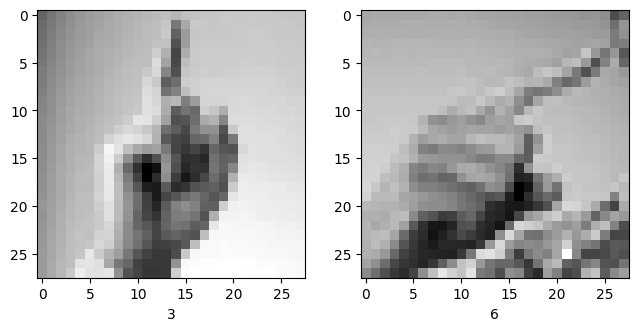

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
images=data.drop('label',axis=1).values
plt.figure(figsize=(16,16))
for i in range(2): 
    img=images[i].reshape(28,28)
    fig = plt.subplot(4,4,i+1)
    plt.xlabel(data['label'][i])
    plt.imshow(img, cmap='gray')

Z danych testowych pozbywamy sie etykiet i etykiety te przypisujemy do oddzielnego zbioru przeznaczonego na etykiety wlasnie

Nastepnie ustalamy odpowiedni wymiar danych i przeskalowujemy nasze dane na wartosci z przedzialu [0,1]

Na koniec zakodywujemy etykiety za pomocą kategorii

In [9]:
x_train = data.drop('label',axis=1)
y = data.label

x_train = x_train.values.reshape(-1,28,28,1)
x_train = x_train/255

y_train = keras.utils.to_categorical(y) 

x_train.shape

(27455, 28, 28, 1)

Jesli istnieje folder z logami naszego modelu to pozbywamy sie go zeby dane nowego modelu mozna bylo pozniej uzyc w tensorboardzie 

In [10]:
%rm -rf ./logs/

Tworzymy callback za pomoca ktorego bedziemy mogli potem otrzymac informacje o procesie uczenia modelu w tensorboardzie

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Kompilujemy i fitujemy model z wczesniej zdefiniowanym callbackiem

In [12]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history=model.fit(x_train,y_train, epochs=15 ,validation_split=0.3, callbacks=[tensorboard_callback])

Epoch 1/15
601/601 [==============================] - 6s 10ms/step - loss: 3.0001 - accuracy: 0.1589 - val_loss: 2.6119 - val_accuracy: 0.2644
Epoch 2/15
601/601 [==============================] - 6s 10ms/step - loss: 2.0903 - accuracy: 0.4090 - val_loss: 1.6839 - val_accuracy: 0.5015
Epoch 3/15
601/601 [==============================] - 6s 10ms/step - loss: 1.4188 - accuracy: 0.5819 - val_loss: 1.2311 - val_accuracy: 0.6109
Epoch 4/15
601/601 [==============================] - 6s 10ms/step - loss: 1.0732 - accuracy: 0.6754 - val_loss: 1.0133 - val_accuracy: 0.6695
Epoch 5/15
601/601 [==============================] - 6s 10ms/step - loss: 0.8603 - accuracy: 0.7372 - val_loss: 0.7790 - val_accuracy: 0.7497
Epoch 6/15
601/601 [==============================] - 6s 9ms/step - loss: 0.7068 - accuracy: 0.7813 - val_loss: 0.6407 - val_accuracy: 0.7982
Epoch 7/15
601/601 [==============================] - 6s 10ms/step - loss: 0.5783 - accuracy: 0.8241 - val_loss: 0.5168 - val_accuracy: 0.8486


Aby wykorzystac mozliwosci ktore gwarantuje nam TensorBoard nalezy uzyc nastepujacej komendy w konsoli

```sh
tensorboard --logdir logs/fit
```


In [ ]:
%tensorboard --logdir logs/fit